### Implementação

Começamos por importar o módulo pysmt.shortcuts que oferece uma API simplificada que disponibiliza as funcionalidades para a utilização usual de um SMT solver. Os tipos estão definidos no módulo pysmt.typing de onde temos que importar o tipo INT e o BVType (para utilização de bit vectors)

In [1]:
from pysmt.shortcuts import *
from pysmt.typing import INT

A seguinte função cria a 𝑖-ésima cópia das variáveis de estado, agrupadas num dicionário que nos permite aceder às mesmas pelo nome.

###  Parâmetros do programa

- **a** e **b**: dois valores inteiros que serão multiplicados
- **n**: precisão limitada (em bits)

In [2]:
a = 4
b = 2
n = 4 

### Função declare

A seguinte função cria a  𝑖-ésima cópia das variáveis de estado, agrupadas num dicionário que nos permite aceder às mesmas pelo nome.

**x**, **y** e **z** são bit vectors e **pc** (program counter) é um inteiro

In [3]:
def declare(i):
    state = {}
    state['pc'] = Symbol('pc' + str(i), INT)
    state['x'] = Symbol('x' + str(i), BVType(n))
    state['y'] = Symbol('y' + str(i), BVType(n))
    state['z'] = Symbol('z' + str(i), BVType(n))
    return state

### Função init

Dado um possível estado do programa (um dicionário de variáveis), devolve um predicado do pySMT que testa se esse estado é um possível estado inicial do programa.

Analisando o Control Flow Automaton do enunciado do problema, definimos que o estado inicial corresponde a esta parte do diagrama:

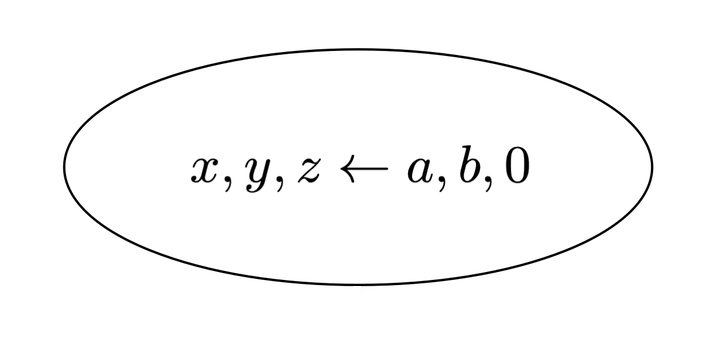

O diagrama exige que neste estado tenhamos:

- x igual a **a** (a é parâmetro do programa e é inteiro)
- y igual a **b** (b é parâmetro do programa e é inteiro)
- z igual a **0**

Adicionalmente, definimos que o **program counter** do nosso estado inicial é 0

Como **x**, **y**, **z** serão bit vectors, construímos um predicado assumindo os valores inteiros enunciados acima no formato de bit vectors com precisão limitada de **n** bits

In [4]:
def init(state):
    return And(Equals(state['pc'], Int(0)), Equals(state['x'], BV(a, n)), Equals(state['y'], BV(b, n)), Equals(state['z'], BVZero(n)))

## Função trans

Dados dois possíveis estados do programa, devolve um predicado do pySMT que testa se é possível transitar do primeiro para o segundo.

Esta função contém todas as transições possíveis dentro do programa, basta que uma se verifique para que possamos transitar do estado **curr** para o **prox**

Vejamos o que cada transição representa no Control Flow Automaton ilustrado no enunciado do trabalho

# t1

- Ocorre imediatamente após o estado inicial
- Representa a passagem do **program counter** (**pc**) de 0 para 1
- Os valores de **x**, **y**, **z** mantém-se iguais

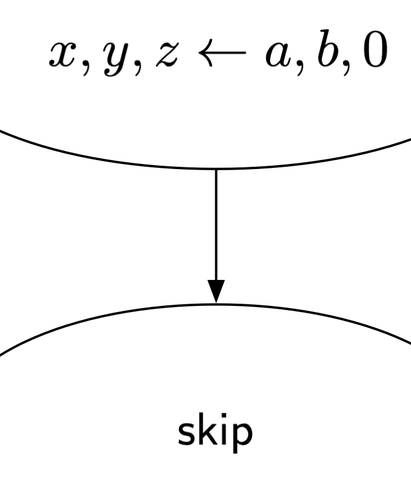

# t2 (não overflow) e t3 (overflow)

t2:

- Ocorre quando o valor de y é par, isto é, quando o bit menos significativo é 0 e quando y é diferente de 0 e quando não há overflow
- Representa a passagem do **program counter** (**pc**) de 1 para 2
- O valor de **x** é duplicado
- O valor de **y** é dividido por 2
- O valor de **z** mantém-se

t3:

- Ocorre quando o valor de y é par, isto é, quando o bit menos significativo é 0 e quando y é diferente de 0 e quando há overflow
- Representa a passagem do **program counter** (**pc**) de 1 para -1
- O valor de **x** é duplicado
- O valor de **y** é dividido por 2
- O valor de **z** mantém-se


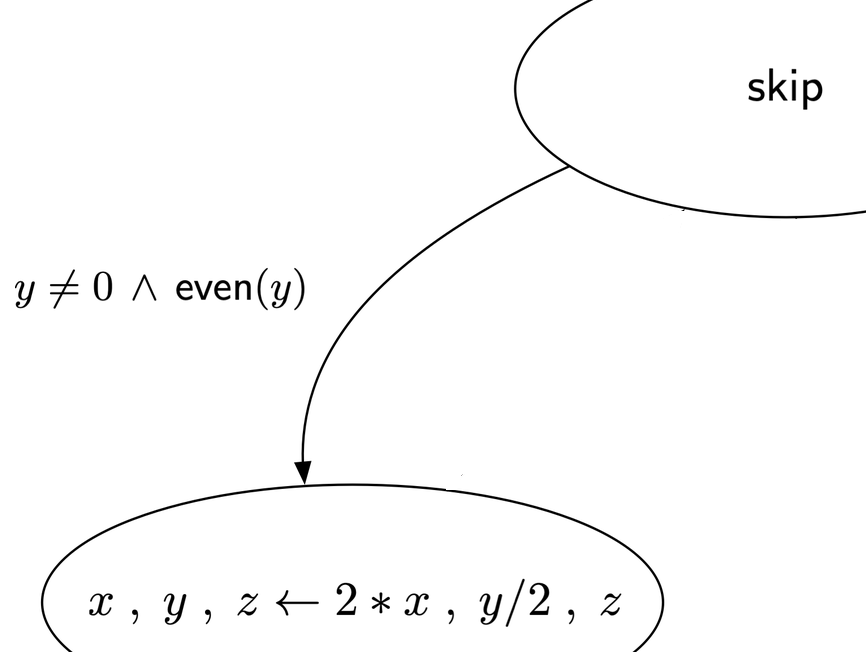

# t4

- Ocorre após imediatamente após efetuar t2
- Representa a passagem do **program counter** (**pc**) de 2 para 1
- Os valores de **x**, **y**, **z** mantém-se iguais

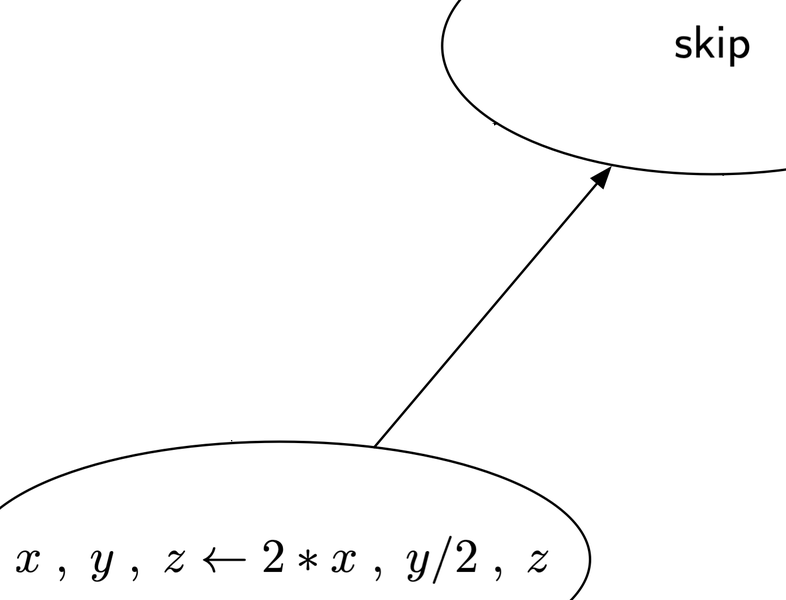

# t5 (não overflow) e t6 (overflow)

t5:

- Ocorre quando o valor de y é ímpar, isto é, quando o bit menos significativo é 1 e quando y é diferente de 0 e quando não há overflow
- Representa a passagem do **program counter** (**pc**) de 1 para 3
- O valor de **x** mantém-se
- Ao valor de **y** subtraí-se 1 
- Ao valor de **z** adiciona-se o valor de **x**

t6:

- Ocorre quando o valor de y é ímpar, isto é, quando o bit menos significativo é 1 e quando y é diferente de 0 e quando há overflow
- Representa a passagem do **program counter** (**pc**) de 1 para -1
- O valor de **x** mantém-se
- Ao valor de **y** subtraí-se 1 
- Ao valor de **z** adiciona-se o valor de **x**

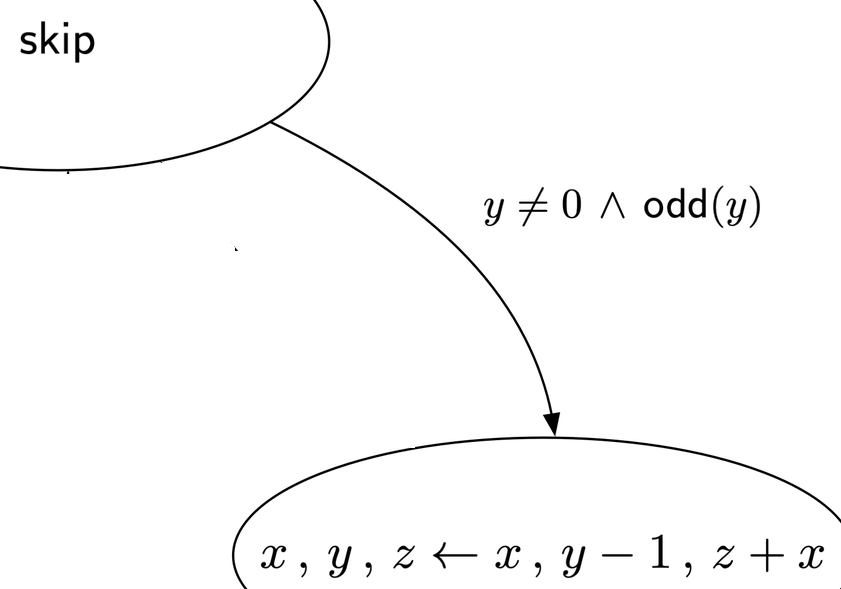

# t7

- Ocorre após imediatamente após efetuar t5
- Representa a passagem do **program counter** (**pc**) de 3 para 1
- Os valores de **x**, **y**, **z** mantém-se iguais

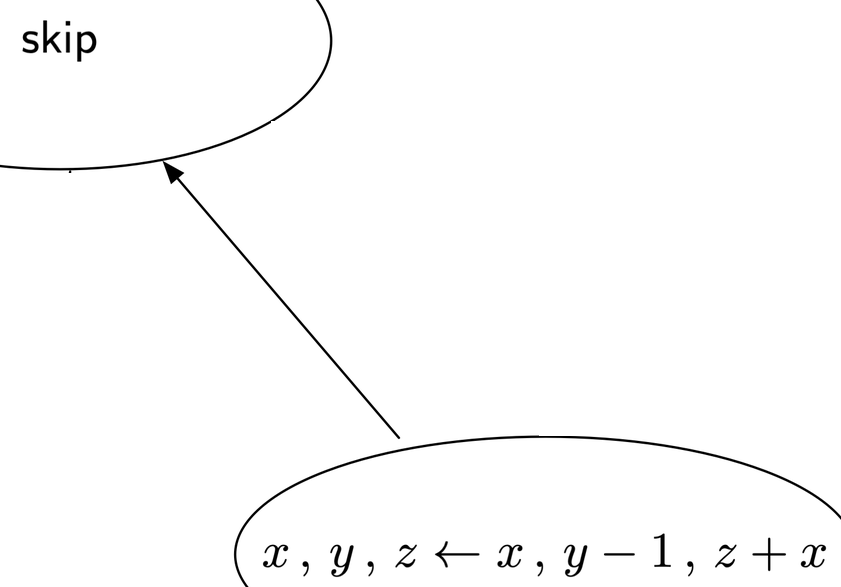

# t8

- Ocorre quando o valor de y é 0
- Representa a passagem do **program counter** (**pc**) de 1 para 4
- Os valores de **x**, **y**, **z** mantém-se iguais

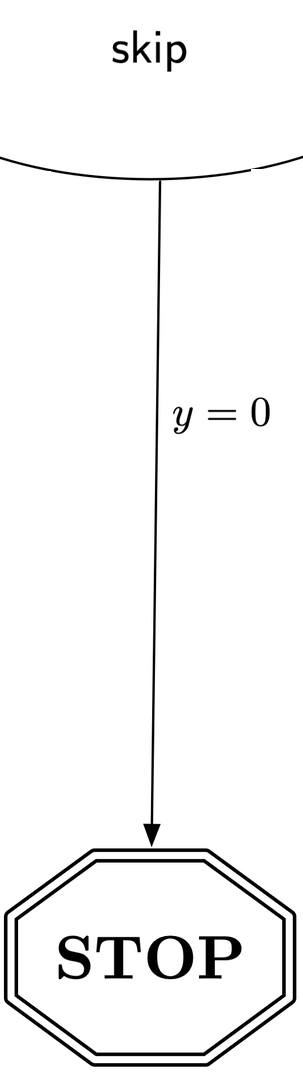

# tSTOP

- Ocorre quando o programa acabou com sucesso
- Representa a passagem do **program counter** (**pc**) de 4 para 4

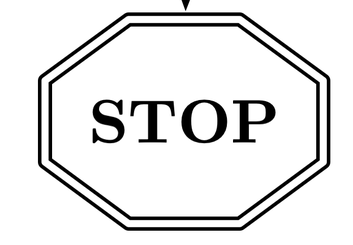

# tERROR

- Ocorre quando o programa acabou sem sucesso
- Representa a passagem do **program counter** (**pc**) de -1 para -1

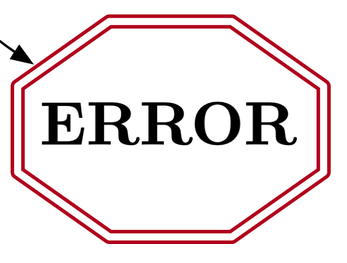

In [5]:
def trans(curr,prox):
    t1 = And(
            Equals(curr['pc'], Int(0)),
            Equals(prox['pc'], Int(1)),
            Equals(prox['x'], curr['x']), 
            Equals(prox['y'], curr['y']), 
            Equals(prox['z'], curr['z']) 
        )     

    t2 = And(
            Equals(curr['pc'], Int(1)),
            Equals(prox['pc'], Int(2)), 
            NotEquals(curr['y'], BVZero(n)), 
            Equals(BVZero(1), BVExtract(curr['y'], start=0, end=0)),
            Equals(prox['x'], BVMul(curr['x'], BV(2, n))),
            Equals(prox['y'], BVUDiv(curr['y'], BV(2, n))),
            Equals(prox['z'], curr['z']),
            Equals(BVUDiv(prox['x'], curr['x']), BV(2, n)),
            )

    t3 = And(
            Equals(curr['pc'], Int(1)),
            Equals(prox['pc'], Int(-1)), 
            NotEquals(curr['y'], BVZero(n)), 
            Equals(BVZero(1), BVExtract(curr['y'], start=0, end=0)),
            Equals(prox['x'], BVMul(curr['x'], BV(2, n))),
            Equals(prox['y'], BVUDiv(curr['y'], BV(2, n))),
            Equals(prox['z'], curr['z']),
            NotEquals(BVUDiv(prox['x'], curr['x']), BV(2, n)),
        )
    
    t4 = And(
            Equals(curr['pc'], Int(2)),
            Equals(prox['pc'], Int(1)),
            Equals(prox['x'], curr['x']), 
            Equals(prox['y'], curr['y']), 
            Equals(prox['z'], curr['z']) 
        )

    t5 = And(
            Equals(curr['pc'], Int(1)),
            Equals(prox['pc'], Int(3)), 
            NotEquals(curr['y'], BVZero(n)), 
            Equals(BVOne(1), BVExtract(curr['y'], start=0, end=0)),
            Equals(prox['x'], curr['x']),
            Equals(prox['y'], BVSub(curr['y'], BV(1, n))),
            Equals(prox['z'], BVAdd(curr['z'], curr['x'])),
            BVUGE(prox['z'], curr['z']) 
        )

    t6 = And(
            Equals(curr['pc'], Int(1)),
            Equals(prox['pc'], Int(-1)), 
            NotEquals(curr['y'], BVZero(n)), 
            Equals(BVOne(1), BVExtract(curr['y'], start=0, end=0)),
            Equals(prox['x'], curr['x']),
            Equals(prox['y'], BVSub(curr['y'], BV(1, n))),
            Equals(prox['z'], BVAdd(curr['z'], curr['x'])),
            BVULE(prox['z'], curr['z'])
        )

    t7 = And(
            Equals(curr['pc'], Int(3)),
            Equals(prox['pc'], Int(1)),
            Equals(prox['x'], curr['x']), 
            Equals(prox['y'], curr['y']), 
            Equals(prox['z'], curr['z']),
        )

    t8 = And(
            Equals(curr['pc'], Int(1)),
            Equals(prox['pc'], Int(4)),
            Equals(curr['y'], BVZero(n)),
            Equals(prox['x'], curr['x']), 
            Equals(prox['y'], curr['y']), 
            Equals(prox['z'], curr['z']) 
    )

    tSTOP = And(
                Equals(curr['pc'], Int(4)),
                Equals(prox['pc'], Int(4)),
                Equals(prox['x'], curr['x']), 
                Equals(prox['y'], curr['y']), 
                Equals(prox['z'], curr['z']) 
            )


    tERROR = And(
                Equals(curr['pc'], Int(-1)),
                Equals(prox['pc'], Int(-1)),
                Equals(prox['x'], curr['x']), 
                Equals(prox['y'], curr['y']), 
                Equals(prox['z'], curr['z']) 
            )

    return Or(t1, t2, t3, t4, t5, t6, t7, t8, tSTOP, tERROR)

## Função gera_traco

Dada uma função que gera uma cópia das variáveis do estado, um predicado que testa se um estado é inicial, um predicado que testa se um par de estados é uma transição válida, e um número positivo k, utilizamos o SMT solver para gerar um possível traço de execução do programa de tamanho k. Para cada estado do traço imprimimos o respectivo valor das variáveis.

In [6]:
def gera_traco(declare,init,trans,k):

    with Solver(name="z3") as s:
        trace = [declare(i) for i in range(k)]
        
        #adicionar o estado inicial
        s.add_assertion(init(trace[0]))
        
        #adicionar a função ed transição
        for i in range(k-1):
            s.add_assertion(trans(trace[i], trace[i+1]))
        
        if s.solve():
            for i in range(k):
                print("Passo", i)
                for v in trace[i]:
                    print(v, "=", s.get_value(trace[i][v]))
                print("--------------")

# gera_traco(declare,init,trans,20)

## Função inv

Dado um possível estado do programa (um dicionário de variáveis), devolve um predicado do pySMT que testa se nesse estado  **x** * **y** + **z** = **a** * **b**, que é o invariante que queremos verificar

In [7]:
def inv(state):
    return Equals(BVAdd(BVMul(state['x'], state['y']), state['z']), BVMul(BV(a, n), BV(b, n)))

## Verificação indutiva de invariantes

No caso da verificação de propriedades de segurança $G\ \phi$, para verificar o invariante $\phi$ por indução temos que verificar as seguintes condições:
- $\phi$ é válido nos estados iniciais, ou seja, $\mathit{init}(s) \rightarrow \phi(s)$
- Para qualquer estado, assumindo que $\phi$ é verdade, se executarmos uma transição, $\phi$ continua a ser verdade no próximo estado, ou seja, $\phi(s) \wedge \mathit{trans}(s,s') \rightarrow \phi(s')$.

## Função induction_always

Verifica invariantes por indução. 
A função recebe como argumento uma função que gera uma cópia das variáveis do estado, um predicado que testa se um estado é inicial, um predicado que testa se um par de estados é uma transição válida, e o invariante.

Teremos que testar a validade das duas condições acima recorrendo à satisfiabilidade, ou seja, usando o solver para encontrar contra-exemplos, devendo o procedimento reportar qual das propriedades falha. Por exemplo, no caso da primeira deve procurar uma valoração que satisfaça $\mathit{init}(s) \wedge \neg \phi(s)$.

In [8]:
def induction_always(declare,init,trans,inv):
    with Solver(name="z3") as s:
        s_now = declare(0)
        s_next = declare(1)
        
        #caso base
        s.push()
        s.add_assertion(init(s_now))
        s.add_assertion(Not(inv(s_now)))
        
        if s.solve():
            #significa que encontramos um contraexemplo
            print("A propriedade não é válida")
            return
        s.pop() #limpa tudo o que foi posto depois do push no solver
        
        #passo de indução
        s.push()
        s.add_assertion(inv(s_now))
        s.add_assertion(trans(s_now, s_next))
        s.add_assertion(Not(inv(s_next)))
        
        if s.solve():
            print("A propriedade não é válida")
            for k in s_now:
                print(k, "=", s.get_value(s_now[k]))
            return
        s.pop()

# induction_always(declare, init, trans, inv)

## Verificação do invariante x * y + z = a * b

Como não encontramos contra-exemplos com o caso base e o passo de indução, então o invariante verifica-se